In [2]:
"""Evaluate best trained checkpoint on dev set in NEWS"""
import os, sys
import ujson as json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms as transforms
import utils
import train
import re
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from tqdm import tqdm
from transformers import DistilBertModel, AlbertModel
from args import get_train_args
from models import DistilBERT, ALBERT
from utils import NEWS, collate_fn

%load_ext autoreload
%autoreload 2

In [2]:
"""Utility methods"""
def get_model(args, device):
    if args.name == 'DistilBERT':
        model = DistilBERT
    elif args.name == 'ALBERT':
        model = ALBERT
        
    model = model(args.hidden_size, args.num_labels,
                  drop_prob=args.drop_prob,
                  freeze=args.freeze,
                  use_img=args.use_img,
                  img_size=args.img_size)
    model = nn.DataParallel(model, args.gpu_ids)
    model = model.to(device)
    
    return model

def get_data_loader(args, record_file):
    transform = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
    dataset = NEWS(record_file, transform=transform)
    data_loader = data.DataLoader(dataset,
                                  batch_size=args.batch_size,
                                  shuffle=False,
                                  num_workers=args.num_workers,
                                  collate_fn=collate_fn)
    
    return data_loader

In [28]:
"""Get F1 score of a model"""
def get_models_F1(args):
    device, args.gpu_ids = utils.get_available_devices()

    model = get_model(args, device)
    data_loader = get_data_loader(args, args.dev_record_file)
    
    base_dir = './save/train/'
    for ckpt_dir in os.listdir(base_dir):
        if args.name in ckpt_dir:
            checkpoint_path = os.path.join(base_dir, ckpt_dir, 'best.pth.tar')
            ckpt_dict = torch.load(checkpoint_path, map_location=device)
            
            # Build model, load parameters
            model.load_state_dict(ckpt_dict['model_state'])
            
            # Evaluate
            results, pred_dict= train.evaluate(model, data_loader, device)
            print(f'{ckpt_dir}: F1 {results["F1"]:.2f},F2 {results["F2"]:.2f},F3 {results["F3"]:.2f},F4 {results["F4"]:.2f}')

name = 'DistilBERT'
use_img = 'False'
dev_record_file = './data/dev.npz'
batch_size = '8'
sys.argv = ['args.py', '--name', name,
            '--use_img', use_img,
            '--dev_record_file', dev_record_file,
            '--batch_size', batch_size]
get_models_F1(get_train_args())

All TF 2.0 model weights were used when initializing DistilBertModel.

All the weights of DistilBertModel were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertModel for predictions without further training.
100%|██████████| 553/553 [06:08<00:00,  1.50it/s, NLL=5.77]

DistilBERT-01: F1 100.00,F2 75.00,F3 100.00,F4 100.00


All TF 2.0 model weights were used when initializing DistilBertModel.

All the weights of DistilBertModel were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertModel for predictions without further training.
100%|██████████| 128/128 [01:37<00:00,  1.32it/s, NLL=77.9]


DistilBERT-01: F1 93.75,F2 91.41,F3 85.16,F4 99.22
128


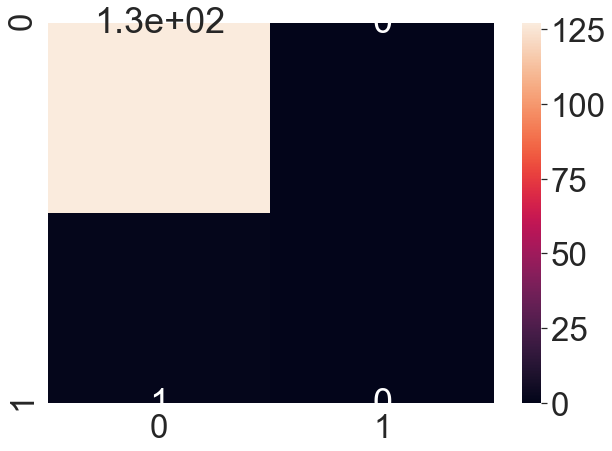

In [14]:
"""Analyze model with confusion matrix then print out the incorrect predictions"""
def model_predict(args, ckpt_dir, record_file):
    # Set up device, model, data_loader
    device, args.gpu_ids = utils.get_available_devices()
    model = get_model(args, device)
    data_loader = get_data_loader(args, record_file)
    
    # load model
    ckpt_path = os.path.join(args.save_dir, 'train', ckpt_dir, 'best.pth.tar')
    ckpt_dict = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt_dict['model_state'])
            
    # Evaluate
    results, pred_dict = train.evaluate(model, data_loader, device)
    print(f'{ckpt_dir}: F1 {results["F1"]:.2f},F2 {results["F2"]:.2f},F3 {results["F3"]:.2f},F4 {results["F4"]:.2f}')

    return pred_dict

def plot_confusion_matrix(pred_dict):
    y_pred = []
    y_true = []
    print(len(pred_dict))
    for value in pred_dict.values():
        pred = [str(x) for x in value[0]]
        label = [re.sub('.0','',str(x)) for x in value[1]]
        for i in range(3,4):
            y_pred.append(pred[i])
            y_true.append(label[i])
#     print(y_pred, y_true)
#     y_pred, y_true =  zip(*pred_dict.values())
    cm = confusion_matrix(y_true, y_pred)
    with open('./data/cat2idx.json', 'r') as fh:
        cat2idx = json.load(fh)
    labels = [label[0] for label in sorted(cat2idx.items(), key=lambda x: x[1])]
#     print(labels)
    sns.set(font_scale=3)
    sns.heatmap(cm, annot=True)
    plt.show()
    
    return cat2idx

def print_wrong_pred(pred_dict):
    incorrect_idxs = [idx for idx, result in pred_dict.items() if result[0] != result[1]]
    idx2cat = {idx: cat for cat, idx in cat2idx.items()}

    for idx in incorrect_idxs:
        pred_label = idx2cat[pred_dict[idx][0]]
        true_label = idx2cat[pred_dict[idx][1]]
        print(f'{idx:4d} prediction: {pred_label:10s} true: {true_label:10s}')

name = 'DistilBERT'
use_img = 'False'
record_file = './data/test.npz'
sys.argv = ['args.py', '--name', name,
            '--use_img', use_img]
ckpt_dir = 'DistilBERT-01'
pred_dict = model_predict(get_train_args(), ckpt_dir, record_file)
cat2idx = plot_confusion_matrix(pred_dict)
# print_wrong_pred(pred_dict)

In [24]:
import shap
import transformers
import nlp
import torch
import numpy as np
import scipy as sp
# load a BERT sentiment analysis model
tokenizer = transformers.DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model = transformers.DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english"
)

# define a prediction function
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=500, truncation=True) for v in x])
    outputs = model(tv)[0].detach().cpu().numpy()
    print(outputs)
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    return val

# build an explainer using a token masker
explainer = shap.Explainer(f, tokenizer)

# explain the model's predictions on IMDB reviews
imdb_train = nlp.load_dataset("imdb")["train"]
shap_values = explainer(imdb_train[:10])
shap.plots.text(shap_values[3])

[[ 1.1581608 -1.0071534]]
[[ 1.9931258 -1.7362273]]
[[ 1.9931257 -1.736227 ]
 [ 1.1581608 -1.0071535]]
[[ 1.1581608 -1.0071534]
 [ 1.9931257 -1.7362272]
 [ 1.1581608 -1.0071534]
 [ 1.9931257 -1.7362272]]
[[ 1.4969848 -1.3257985]
 [ 1.5883845 -1.357199 ]
 [ 1.4969848 -1.3257985]
 [ 1.5883845 -1.357199 ]
 [ 1.4969848 -1.3257985]
 [ 1.5883845 -1.357199 ]]


[[ 1.4969848 -1.3257985]
 [ 1.5883845 -1.357199 ]
 [ 1.6701291 -1.4708681]
 [ 1.8342867 -1.5993218]
 [ 1.6701291 -1.4708681]
 [ 1.8342867 -1.5993218]]
[[ 1.6701291  -1.4708681 ]
 [ 1.8342867  -1.5993218 ]
 [ 1.6701291  -1.4708681 ]
 [ 1.8342867  -1.5993218 ]
 [ 2.0232184  -1.7577533 ]
 [ 0.33145046 -0.11604249]]
[[ 1.4641972  -1.2534423 ]
 [ 1.5461669  -1.278065  ]
 [ 0.81330466 -0.56742364]
 [ 1.7645812  -1.518823  ]
 [ 2.0232184  -1.7577533 ]
 [ 0.33145046 -0.11604249]]
[[ 1.4641972  -1.2534423 ]
 [ 1.5461669  -1.278065  ]
 [ 0.81330466 -0.56742364]
 [ 1.7645812  -1.518823  ]
 [ 2.0232184  -1.7577533 ]
 [ 0.33145046 -0.11604249]]
[[ 1.4641972  -1.2534423 ]
 [ 1.5461669  -1.278065  ]
 [ 0.81330466 -0.56742364]
 [ 1.7645812  -1.518823  ]
 [ 2.0232184  -1.7577533 ]
 [ 0.33145046 -0.11604249]]




Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (559 > 512). Running this sequence through the model will result in indexing errors


[[ 1.4641972  -1.2534423 ]
 [ 1.5461669  -1.278065  ]
 [ 0.81330466 -0.56742364]
 [ 1.7645812  -1.518823  ]
 [ 1.4161866  -1.2314057 ]
 [ 1.4621422  -1.2351356 ]]
[[ 0.36843094 -0.35418862]]
[[ 2.2542    -1.8741273]]
[[ 2.2542     -1.8741274 ]
 [ 0.3684309  -0.35418862]]
[[ 0.3684309  -0.35418862]
 [ 2.2542     -1.8741273 ]
 [ 0.3684309  -0.35418862]
 [ 2.2542     -1.8741273 ]]
[[ 0.99158204 -0.760075  ]
 [ 2.0568962  -1.7740388 ]
 [ 0.99158204 -0.760075  ]
 [ 2.0568962  -1.7740388 ]
 [ 0.99158204 -0.760075  ]
 [ 2.0568962  -1.7740388 ]]


[[ 0.99158204 -0.760075  ]
 [ 2.0568962  -1.7740388 ]
 [ 2.654239   -2.3010106 ]
 [-0.23358597  0.24127129]
 [ 2.654239   -2.3010106 ]
 [-0.23358597  0.24127129]]
[[ 2.654239   -2.3010106 ]
 [-0.23358597  0.24127129]
 [ 2.654239   -2.3010106 ]
 [-0.23358597  0.24127129]
 [ 2.8664317  -2.4612064 ]
 [-2.2266774   2.2210822 ]]
[[-1.8580341   1.8559542 ]
 [ 1.5332568  -1.2625213 ]
 [-2.2266774   2.2210822 ]
 [ 0.99158204 -0.760075  ]
 [ 2.8664317  -2.4612064 ]
 [-2.2266774   2.2210822 ]]
[[-1.8580341   1.8559542 ]
 [ 1.5332568  -1.2625213 ]
 [-2.2266774   2.2210822 ]
 [ 0.99158204 -0.760075  ]
 [ 2.8664317  -2.4612064 ]
 [-2.2266774   2.2210822 ]]
[[-1.8580341   1.8559542 ]
 [ 1.5332568  -1.2625213 ]
 [-2.2266774   2.2210822 ]
 [ 0.99158204 -0.760075  ]
 [ 2.8664317  -2.4612064 ]
 [-2.2266774   2.2210822 ]]




Partition explainer: 3it [01:09, 17.37s/it]               

[[-1.8580341   1.8559542 ]
 [ 1.5332568  -1.2625213 ]
 [-2.2266774   2.2210822 ]
 [ 0.99158204 -0.760075  ]
 [-0.9361367   0.96775883]
 [ 1.7137575  -1.5048152 ]]
[[ 1.1689717 -1.0154146]]
[[-2.0823581  2.2645407]]
[[-2.0823581  2.2645402]
 [ 1.1689717 -1.0154147]]
[[ 1.1689717 -1.0154147]
 [-2.0823584  2.2645402]
 [ 1.1689717 -1.0154147]
 [-2.0823584  2.2645402]]
[[-2.217577   2.3834472]
 [ 1.0078933 -0.8074271]
 [-2.217577   2.3834472]
 [ 1.0078933 -0.8074271]
 [-2.217577   2.3834472]
 [ 1.0078933 -0.8074271]]


[[-2.217577   2.3834472]
 [ 1.0078933 -0.8074271]
 [-1.565408   1.6523247]
 [-1.7126877  1.8275402]
 [-1.565408   1.6523247]
 [-1.7126877  1.8275402]]
[[-1.565408   1.6523247]
 [-1.7126877  1.8275402]
 [-1.565408   1.6523247]
 [-1.7126877  1.8275402]
 [-0.9762202  1.1699392]
 [-1.497741   1.6733856]]
[[-0.9762202  1.1699392]
 [-1.497741   1.6733856]
 [-0.9762202  1.1699392]
 [-1.497741   1.6733856]
 [-0.9762202  1.1699392]
 [-1.497741   1.6733856]]
[[-1.8122176  1.9070859]
 [ 1.934398  -1.6950575]
 [-1.8122176  1.9070859]
 [ 1.934398  -1.6950575]
 [-1.8122176  1.9070859]
 [ 1.934398  -1.6950575]]
[[-1.8122176   1.9070859 ]
 [ 1.934398   -1.6950575 ]
 [ 0.03365061  0.19559185]
 [-0.0036221   0.10759099]
 [ 0.03365061  0.19559185]
 [-0.0036221   0.10759099]]




Partition explainer: 4it [01:42, 22.13s/it]

[[ 0.03365061  0.19559185]
 [-0.0036221   0.10759099]
 [ 0.03365061  0.19559185]
 [-0.0036221   0.10759099]
 [-1.6075231   1.773694  ]
 [ 1.5166748  -1.2596145 ]]
[[ 1.1631793 -1.0081167]]
[[-1.7696034  1.8637645]]
[[-1.7696033  1.8637648]
 [ 1.1631793 -1.0081167]]
[[ 1.1631793 -1.0081168]
 [-1.7696034  1.8637645]
 [ 1.1631793 -1.0081168]
 [-1.7696034  1.8637645]]
[[ 2.2971587 -1.9910022]
 [-2.2024899  2.3030362]
 [ 2.2971587 -1.9910022]
 [-2.2024899  2.3030362]
 [ 2.2971587 -1.9910022]
 [-2.2024899  2.3030362]]


[[ 2.2971587 -1.9910022]
 [-2.2024899  2.3030362]
 [-2.053895   2.1327844]
 [ 2.6409667 -2.2728438]
 [-2.053895   2.1327844]
 [ 2.6409667 -2.2728438]]
[[-2.053895   2.1327844]
 [ 2.6409667 -2.2728438]
 [-2.053895   2.1327844]
 [ 2.6409667 -2.2728438]
 [-2.3169572  2.42788  ]
 [ 1.7285892 -1.5143467]]
[[-2.3169572  2.42788  ]
 [ 1.7285892 -1.5143467]
 [-2.3169572  2.42788  ]
 [ 1.7285892 -1.5143467]
 [-2.3169572  2.42788  ]
 [ 1.7285892 -1.5143467]]
[[-0.728737   0.8605795]
 [-0.6278561  0.7993096]
 [-0.728737   0.8605795]
 [-0.6278561  0.7993096]
 [-0.728737   0.8605795]
 [-0.6278561  0.7993096]]
[[-0.728737   0.8605795]
 [-0.6278561  0.7993096]
 [-1.1675324  1.2583821]
 [-1.3716292  1.4708426]
 [-1.1675324  1.2583821]
 [-1.3716292  1.4708426]]




Partition explainer: 5it [02:18, 26.03s/it]

[[-1.1675324  1.2583821]
 [-1.3716292  1.4708426]
 [-1.1675324  1.2583821]
 [-1.3716292  1.4708426]
 [-1.5015553  1.5701268]
 [-1.7730889  1.8961885]]
[[ 1.1586641 -1.0047336]]
[[-0.6771175  0.8723309]]
[[-0.6771175   0.87233084]
 [ 1.158664   -1.0047333 ]]
[[ 1.1586641 -1.0047336]
 [-0.6771176  0.8723309]
 [ 1.1586641 -1.0047336]
 [-0.6771176  0.8723309]]
[[ 1.8665178 -1.5863214]
 [-0.8944037  1.0505624]
 [ 1.8665178 -1.5863214]
 [-0.8944037  1.0505624]
 [ 1.8665178 -1.5863214]
 [-0.8944037  1.0505624]]


[[ 1.8665178  -1.5863214 ]
 [-0.8944037   1.0505624 ]
 [-0.36899394  0.59051824]
 [ 1.6176044  -1.3435506 ]
 [-0.36899394  0.59051824]
 [ 1.6176044  -1.3435506 ]]
[[-0.36899394  0.59051824]
 [ 1.6176044  -1.3435506 ]
 [-0.36899394  0.59051824]
 [ 1.6176044  -1.3435506 ]
 [-0.12089218  0.31202447]
 [ 0.9108922  -0.74697554]]
[[-0.12089218  0.31202447]
 [ 0.9108922  -0.74697554]
 [-0.12089218  0.31202447]
 [ 0.9108922  -0.74697554]
 [-0.12089218  0.31202447]
 [ 0.9108922  -0.74697554]]
[[ 1.8537488  -1.5510674 ]
 [-0.40204778  0.6090237 ]
 [ 1.8537488  -1.5510674 ]
 [-0.40204778  0.6090237 ]
 [ 1.8537488  -1.5510674 ]
 [-0.40204778  0.6090237 ]]
[[ 1.8537488  -1.5510674 ]
 [-0.40204778  0.6090237 ]
 [ 2.0920892  -1.7652662 ]
 [ 0.23840353 -0.01481125]
 [ 2.0920892  -1.7652662 ]
 [ 0.23840353 -0.01481125]]




Partition explainer: 6it [02:51, 28.19s/it]

[[ 2.0920892  -1.7652662 ]
 [ 0.23840353 -0.01481125]
 [ 2.0920892  -1.7652662 ]
 [ 0.23840353 -0.01481125]
 [ 1.2703507  -1.0694945 ]
 [-0.6188883   0.77406454]]
[[ 1.0285882  -0.91727626]]
[[-0.6444107  0.8089404]]
[[-0.6444106  0.8089405]
 [ 1.0285883 -0.9172764]]
[[ 1.0285883 -0.9172763]
 [-0.6444106  0.8089405]
 [ 1.0285883 -0.9172763]
 [-0.6444106  0.8089405]]
[[ 2.254784  -1.9730005]
 [-1.7178899  1.823715 ]
 [ 2.254784  -1.9730005]
 [-1.7178899  1.823715 ]
 [ 2.254784  -1.9730005]
 [-1.7178899  1.823715 ]]


[[ 2.254784   -1.9730005 ]
 [-1.7178899   1.823715  ]
 [ 1.055205   -0.81323445]
 [-0.8369404   0.9656478 ]
 [ 1.055205   -0.81323445]
 [-0.8369404   0.9656478 ]]
[[ 1.055205   -0.81323445]
 [-0.8369404   0.9656478 ]
 [ 1.055205   -0.81323445]
 [-0.8369404   0.9656478 ]
 [ 0.14537773  0.05795047]
 [-1.5427634   1.5953047 ]]
[[ 0.14537773  0.05795047]
 [-1.5427634   1.5953047 ]
 [ 0.14537773  0.05795047]
 [-1.5427634   1.5953047 ]
 [ 0.14537773  0.05795047]
 [-1.5427634   1.5953047 ]]
[[-0.7488141   0.87839484]
 [ 2.274788   -1.996919  ]
 [-0.7488141   0.87839484]
 [ 2.274788   -1.996919  ]
 [-0.7488141   0.87839484]
 [ 2.274788   -1.996919  ]]
[[-0.7488141   0.87839484]
 [ 2.274788   -1.996919  ]
 [-1.5068674   1.5513898 ]
 [ 1.1781237  -1.040835  ]
 [-1.5068674   1.5513898 ]
 [ 1.1781237  -1.040835  ]]




Partition explainer: 7it [03:33, 32.50s/it]

[[-1.5068674  1.5513898]
 [ 1.1781237 -1.040835 ]
 [-1.5068674  1.5513898]
 [ 1.1781237 -1.040835 ]
 [-1.2219696  1.3227779]
 [ 2.358837  -2.0751755]]
[[ 1.1673828 -1.0123284]]
[[-2.8115034  2.990902 ]]
[[-2.8115034  2.9909024]
 [ 1.167383  -1.0123285]]
[[ 1.1673828 -1.0123286]
 [-2.8115034  2.9909024]
 [ 1.1673828 -1.0123286]
 [-2.8115034  2.9909024]]
[[-2.2105966  2.3399594]
 [-2.716642   2.8740783]
 [-2.2105966  2.3399594]
 [-2.716642   2.8740783]
 [-2.2105966  2.3399594]
 [-2.716642   2.8740783]]


[[-2.2105966   2.3399594 ]
 [-2.716642    2.8740783 ]
 [-2.5504093   2.672008  ]
 [ 0.4886644  -0.36930853]
 [-2.5504093   2.672008  ]
 [ 0.4886644  -0.36930853]]
[[-2.5504093   2.672008  ]
 [ 0.4886644  -0.36930853]
 [-2.5504093   2.672008  ]
 [ 0.4886644  -0.36930853]
 [-2.050469    2.1803293 ]
 [ 0.7606559  -0.613751  ]]
[[-2.050469   2.1803293]
 [ 0.7606559 -0.613751 ]
 [-2.050469   2.1803293]
 [ 0.7606559 -0.613751 ]
 [-2.050469   2.1803293]
 [ 0.7606559 -0.613751 ]]
[[-2.1648717  2.263157 ]
 [-1.2617393  1.3186226]
 [-2.1648717  2.263157 ]
 [-1.2617393  1.3186226]
 [-2.1648717  2.263157 ]
 [-1.2617393  1.3186226]]
[[-2.1648717  2.263157 ]
 [-1.2617393  1.3186226]
 [-2.3748336  2.498335 ]
 [-1.7821101  1.8806574]
 [-2.3748336  2.498335 ]
 [-1.7821101  1.8806574]]




Partition explainer: 8it [04:13, 34.73s/it]

[[-2.3748336  2.498335 ]
 [-1.7821101  1.8806574]
 [-2.3748336  2.498335 ]
 [-1.7821101  1.8806574]
 [ 1.2591461 -1.0745454]
 [-2.2396064  2.3865378]]
[[ 0.36843094 -0.35418862]]
[[-2.3321652  2.4078724]]
[[-2.3321652   2.4078727 ]
 [ 0.3684309  -0.35418862]]
[[ 0.3684309  -0.35418862]
 [-2.3321655   2.4078727 ]
 [ 0.3684309  -0.35418862]
 [-2.3321655   2.4078727 ]]
[[-0.64501774  0.70552045]
 [-1.8991894   2.0004168 ]
 [-0.64501774  0.70552045]
 [-1.8991894   2.0004168 ]
 [-0.64501774  0.70552045]
 [-1.8991894   2.0004168 ]]


[[-0.64501774  0.70552045]
 [-1.8991894   2.0004168 ]
 [ 0.06915978  0.01775069]
 [-0.57766604  0.6559777 ]
 [ 0.06915978  0.01775069]
 [-0.57766604  0.6559777 ]]
[[ 0.06915978  0.01775069]
 [-0.57766604  0.6559777 ]
 [ 0.06915978  0.01775069]
 [-0.57766604  0.6559777 ]
 [-1.3614101   1.3923423 ]
 [-1.8846      1.9090781 ]]
[[-1.3614101  1.3923423]
 [-1.8846     1.9090781]
 [-1.3614101  1.3923423]
 [-1.8846     1.9090781]
 [-1.3614101  1.3923423]
 [-1.8846     1.9090781]]
[[ 1.0831378  -0.89261055]
 [-0.05549707  0.16281523]
 [ 1.0831378  -0.89261055]
 [-0.05549707  0.16281523]
 [ 1.0831378  -0.89261055]
 [-0.05549707  0.16281523]]
[[ 1.0831378  -0.89261055]
 [-0.05549707  0.16281523]
 [-1.865318    1.9647889 ]
 [ 0.04512332  0.04300579]
 [-1.865318    1.9647889 ]
 [ 0.04512332  0.04300579]]




Partition explainer: 9it [04:49, 35.05s/it]

[[-1.865318    1.9647889 ]
 [ 0.04512332  0.04300579]
 [-1.865318    1.9647889 ]
 [ 0.04512332  0.04300579]
 [ 2.1725595  -1.9214747 ]
 [-1.7775795   1.784673  ]]
[[ 0.36843094 -0.35418862]]
[[-2.25283   2.274956]]
[[-2.2528298   2.2749557 ]
 [ 0.3684309  -0.35418862]]
[[ 0.3684309  -0.35418862]
 [-2.2528298   2.274956  ]
 [ 0.3684309  -0.35418862]
 [-2.2528298   2.274956  ]]
[[-1.9727633  2.0029225]
 [-1.9522789  1.9776677]
 [-1.9727633  2.0029225]
 [-1.9522789  1.9776677]
 [-1.9727633  2.0029225]
 [-1.9522789  1.9776677]]


[[-1.9727633  2.0029225]
 [-1.9522789  1.9776677]
 [-1.8334982  1.8550947]
 [ 1.0944148 -0.8886023]
 [-1.8334982  1.8550947]
 [ 1.0944148 -0.8886023]]
[[-1.8334982   1.8550947 ]
 [ 1.0944148  -0.8886023 ]
 [-1.8334982   1.8550947 ]
 [ 1.0944148  -0.8886023 ]
 [ 0.6098728  -0.52972347]
 [-1.145958    1.2024834 ]]
[[ 0.6098728  -0.52972347]
 [-1.145958    1.2024834 ]
 [ 0.6098728  -0.52972347]
 [-1.145958    1.2024834 ]
 [ 0.6098728  -0.52972347]
 [-1.145958    1.2024834 ]]
[[-1.6864064   1.7384369 ]
 [ 0.36298063 -0.17474595]
 [-1.6864064   1.7384369 ]
 [ 0.36298063 -0.17474595]
 [-1.6864064   1.7384369 ]
 [ 0.36298063 -0.17474595]]
[[-1.6864064   1.7384369 ]
 [ 0.36298063 -0.17474595]
 [-1.9522789   1.9776677 ]
 [ 0.6098728  -0.52972347]
 [-1.9522789   1.9776677 ]
 [ 0.6098728  -0.52972347]]




Partition explainer: 10it [05:26, 35.72s/it]

[[-1.9522789   1.9776677 ]
 [ 0.6098728  -0.52972347]
 [-1.9522789   1.9776677 ]
 [ 0.6098728  -0.52972347]
 [-1.8205136   1.8625057 ]
 [ 1.2176659  -1.0311692 ]]
[[ 0.55809355 -0.54123765]]
[[-3.2246997  3.3723338]]
[[-3.2246993   3.3723338 ]
 [ 0.55809355 -0.5412376 ]]
[[ 0.55809355 -0.54123765]
 [-3.2246995   3.372334  ]
 [ 0.55809355 -0.54123765]
 [-3.2246995   3.372334  ]]


[[-2.3958704  2.5035272]
 [-2.4096272  2.5079312]
 [-2.3958704  2.5035272]
 [-2.4096272  2.5079312]
 [-2.3958704  2.5035272]
 [-2.4096272  2.5079312]]
[[-2.3958704  2.5035272]
 [-2.4096272  2.5079312]
 [ 1.6451524 -1.3971539]
 [-2.567893   2.6377394]
 [ 1.6451524 -1.3971539]
 [-2.567893   2.6377394]]
[[ 1.6451524 -1.3971539]
 [-2.567893   2.6377394]
 [ 1.6451524 -1.3971539]
 [-2.567893   2.6377394]
 [ 1.4535319 -1.2655048]
 [-2.2819235  2.3684833]]
[[ 1.4535319 -1.2655048]
 [-2.2819235  2.3684833]
 [ 1.4535319 -1.2655048]
 [-2.2819235  2.3684833]
 [ 1.4535319 -1.2655048]
 [-2.2819235  2.3684833]]
[[-1.0174077  1.1609154]
 [-1.2947667  1.4200423]
 [-1.0174077  1.1609154]
 [-1.2947667  1.4200423]
 [-1.0174077  1.1609154]
 [-1.2947667  1.4200423]]
[[-1.0174077  1.1609154]
 [-1.2947667  1.4200423]
 [-2.3117442  2.3974428]
 [ 1.9335402 -1.6835339]
 [-2.3117442  2.3974428]
 [ 1.9335402 -1.6835339]]




Partition explainer: 11it [06:06, 33.31s/it]

[[-2.3117442  2.3974428]
 [ 1.9335402 -1.6835339]
 [-2.3117442  2.3974428]
 [ 1.9335402 -1.6835339]
 [-1.0873966  1.0878298]
 [-2.078196   2.1578236]]


In [4]:
import shap
import nlp
import torch
import transformers
import scipy as sp

args = get_train_args()
device, args.gpu_ids = utils.get_available_devices()

# load a BERT sentiment analysis model
tokenizer = transformers.DistilBertTokenizerFast.from_pretrained("distilbert-base-multilingual-cased")
# model = transformers.DistilBertTokenizerFast.from_pretrained("distilbert-base-multilingual-cased")
model = DistilBERT(args.hidden_size, args.num_labels,
                           drop_prob=args.drop_prob,
                           freeze=args.freeze,
                           use_img=args.use_img,
                           img_size=args.img_size)

# load local model
ckpt_dir = 'DistilBERT-01'
ckpt_path = os.path.join(args.save_dir, 'train', ckpt_dir, 'best.pth.tar')
ckpt_dict = torch.load(ckpt_path)
model.load_state_dict(ckpt_dict['model_state'], False)


def get_data_loader(args, record_file):
    transform = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
    dataset = NEWS(record_file, transform=transform)
    data_loader = data.DataLoader(dataset,
                                  batch_size=args.batch_size,
                                  shuffle=False,
                                  num_workers=args.num_workers,
                                  collate_fn=collate_fn)
    
    return data_loader

# define a prediction function
def f(x):
    for input_idxs, atten_masks, y in x:
        # print(input_idxs, atten_masks, y)
        input_idxs = input_idxs.to(device)
        atten_masks = atten_masks.to(device)
        y = y.to(device)
        log_p = model(input_idxs, atten_masks)
        print(log_p)
        loss = torch.nn.functional.binary_cross_entropy(log_p, y, weight=None, size_average=None, reduce=None, reduction='sum')
        loss_val = loss.item()
#         print(loss_val)
#         outputs = model(input_idxs, atten_masks)[0].detach().cpu().numpy()
#         scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
#         val = sp.special.logit(scores[:,1]) # use one vs rest logit units
#         return val
    # outputs = model(tv)[0].detach().cpu().numpy()
    # scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    # val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    # return val

# explain the model's predictions on IMDB reviews
record_file = './data/test.npz'
data_loader = get_data_loader(args, record_file)
val = f(data_loader)
# build an explainer using  a token masker
# explainer = shap.Explainer(f, tokenizer)
# imdb_train = nlp.load_dataset("imdb")["train"]
# shap_values = explainer(data_loader, fixed_context=1)


# print(data_loader)


usage: Train a model on NEWS [-h] [--name NAME]
                             [--raw_data_file RAW_DATA_FILE] [--times TIMES]
                             [--seed SEED]
                             [--train_record_file TRAIN_RECORD_FILE]
                             [--dev_record_file DEV_RECORD_FILE]
                             [--test_record_file TEST_RECORD_FILE]
                             [--save_dir SAVE_DIR] [--load_path LOAD_PATH]
                             [--batch_size BATCH_SIZE]
                             [--hidden_size HIDDEN_SIZE]
                             [--num_workers NUM_WORKERS]
                             [--eval_steps EVAL_STEPS] [--lr_1 LR_1]
                             [--lr_2 LR_2] [--l2_wd L2_WD]
                             [--num_epochs NUM_EPOCHS] [--drop_prob DROP_PROB]
                             [--num_labels NUM_LABELS] [--freeze FREEZE]
                             [--use_img USE_IMG] [--img_size IMG_SIZE]
                             [--metr

SystemExit: 2

In [8]:
import transformers
import shap

# load a transformers pipeline model
model = transformers.pipeline('sentiment-analysis', return_all_scores=True)

# explain the model on two sample inputs
explainer = shap.Explainer(model) 
shap_values = explainer(["What a great movie! ...if you have no taste."])
print(shap_values[0, :, "POSITIVE"])
print(type(shap_values))
# visualize the first prediction's explanation for the POSITIVE output class
# shap.plots.text(shap_values[0, :, "POSITIVE"])

.values =
array([-1.83965726e-07,  1.15300380e+00,  1.15300380e+00,  4.06625983e+00,
        4.06625983e+00,  1.70656413e-01, -1.60968360e-01, -1.60968360e-01,
       -1.60968360e-01, -1.60968360e-01, -1.60968360e-01, -1.60968360e-01,
       -1.60968360e-01, -1.60968360e-01, -1.60968360e-01, -2.45287630e-07])

.base_values =
-0.33786583946352583

.data =
array(['', 'What ', 'a ', 'great ', 'movie', '! ', '.', '.', '.', 'if ',
       'you ', 'have ', 'no ', 'taste', '.', ''], dtype='<U6')
<class 'shap._explanation.Explanation'>
